# Exploratory Data Analysis of the Flu Shot Data:

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
import seaborn as sns

## Load the Data

In [6]:
y_train = pd.read_csv('../Data/Flu_Shot_Learning_Predict_H1N1_and_Seasonal_Flu_Vaccines_-_Training_Labels.csv')
X_test = pd.read_csv('../Data/Flu_Shot_Learning_Predict_H1N1_and_Seasonal_Flu_Vaccines_-_Test_Features.csv')
X_train = pd.read_csv('../Data/Flu_Shot_Learning_Predict_H1N1_and_Seasonal_Flu_Vaccines_-_Training_Features.csv')
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (26707, 36)
Shape of X_test: (26708, 36)
Shape of y_train: (26707, 3)


In [7]:
X_train.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


## Handle Empty (NaN) values


In [16]:
X_train_nas = pd.DataFrame(X_train.isna().sum())
X_train_nas

,0
respondent_id,0
h1n1_concern,92
h1n1_knowledge,116
behavioral_antiviral_meds,71
behavioral_avoidance,208
behavioral_face_mask,19
behavioral_wash_hands,42
behavioral_large_gatherings,87
behavioral_outside_home,82
behavioral_touch_face,128


Clearly there are far too many NA values to possibly remove all of them, as we would remove a significant amount of predictive power. However, we should consider feature selection methods for extracting the most amount of valuable information from our data while omitting useless information.

### Feature Selection (Filter & Wrapper based methods)

1) Filter Based

Here we will investigate the correlation between predictors to investigate potential redundancies

### Dimensionality Reduction (PCA, LDA)

## Analysing the distributions of the predictors

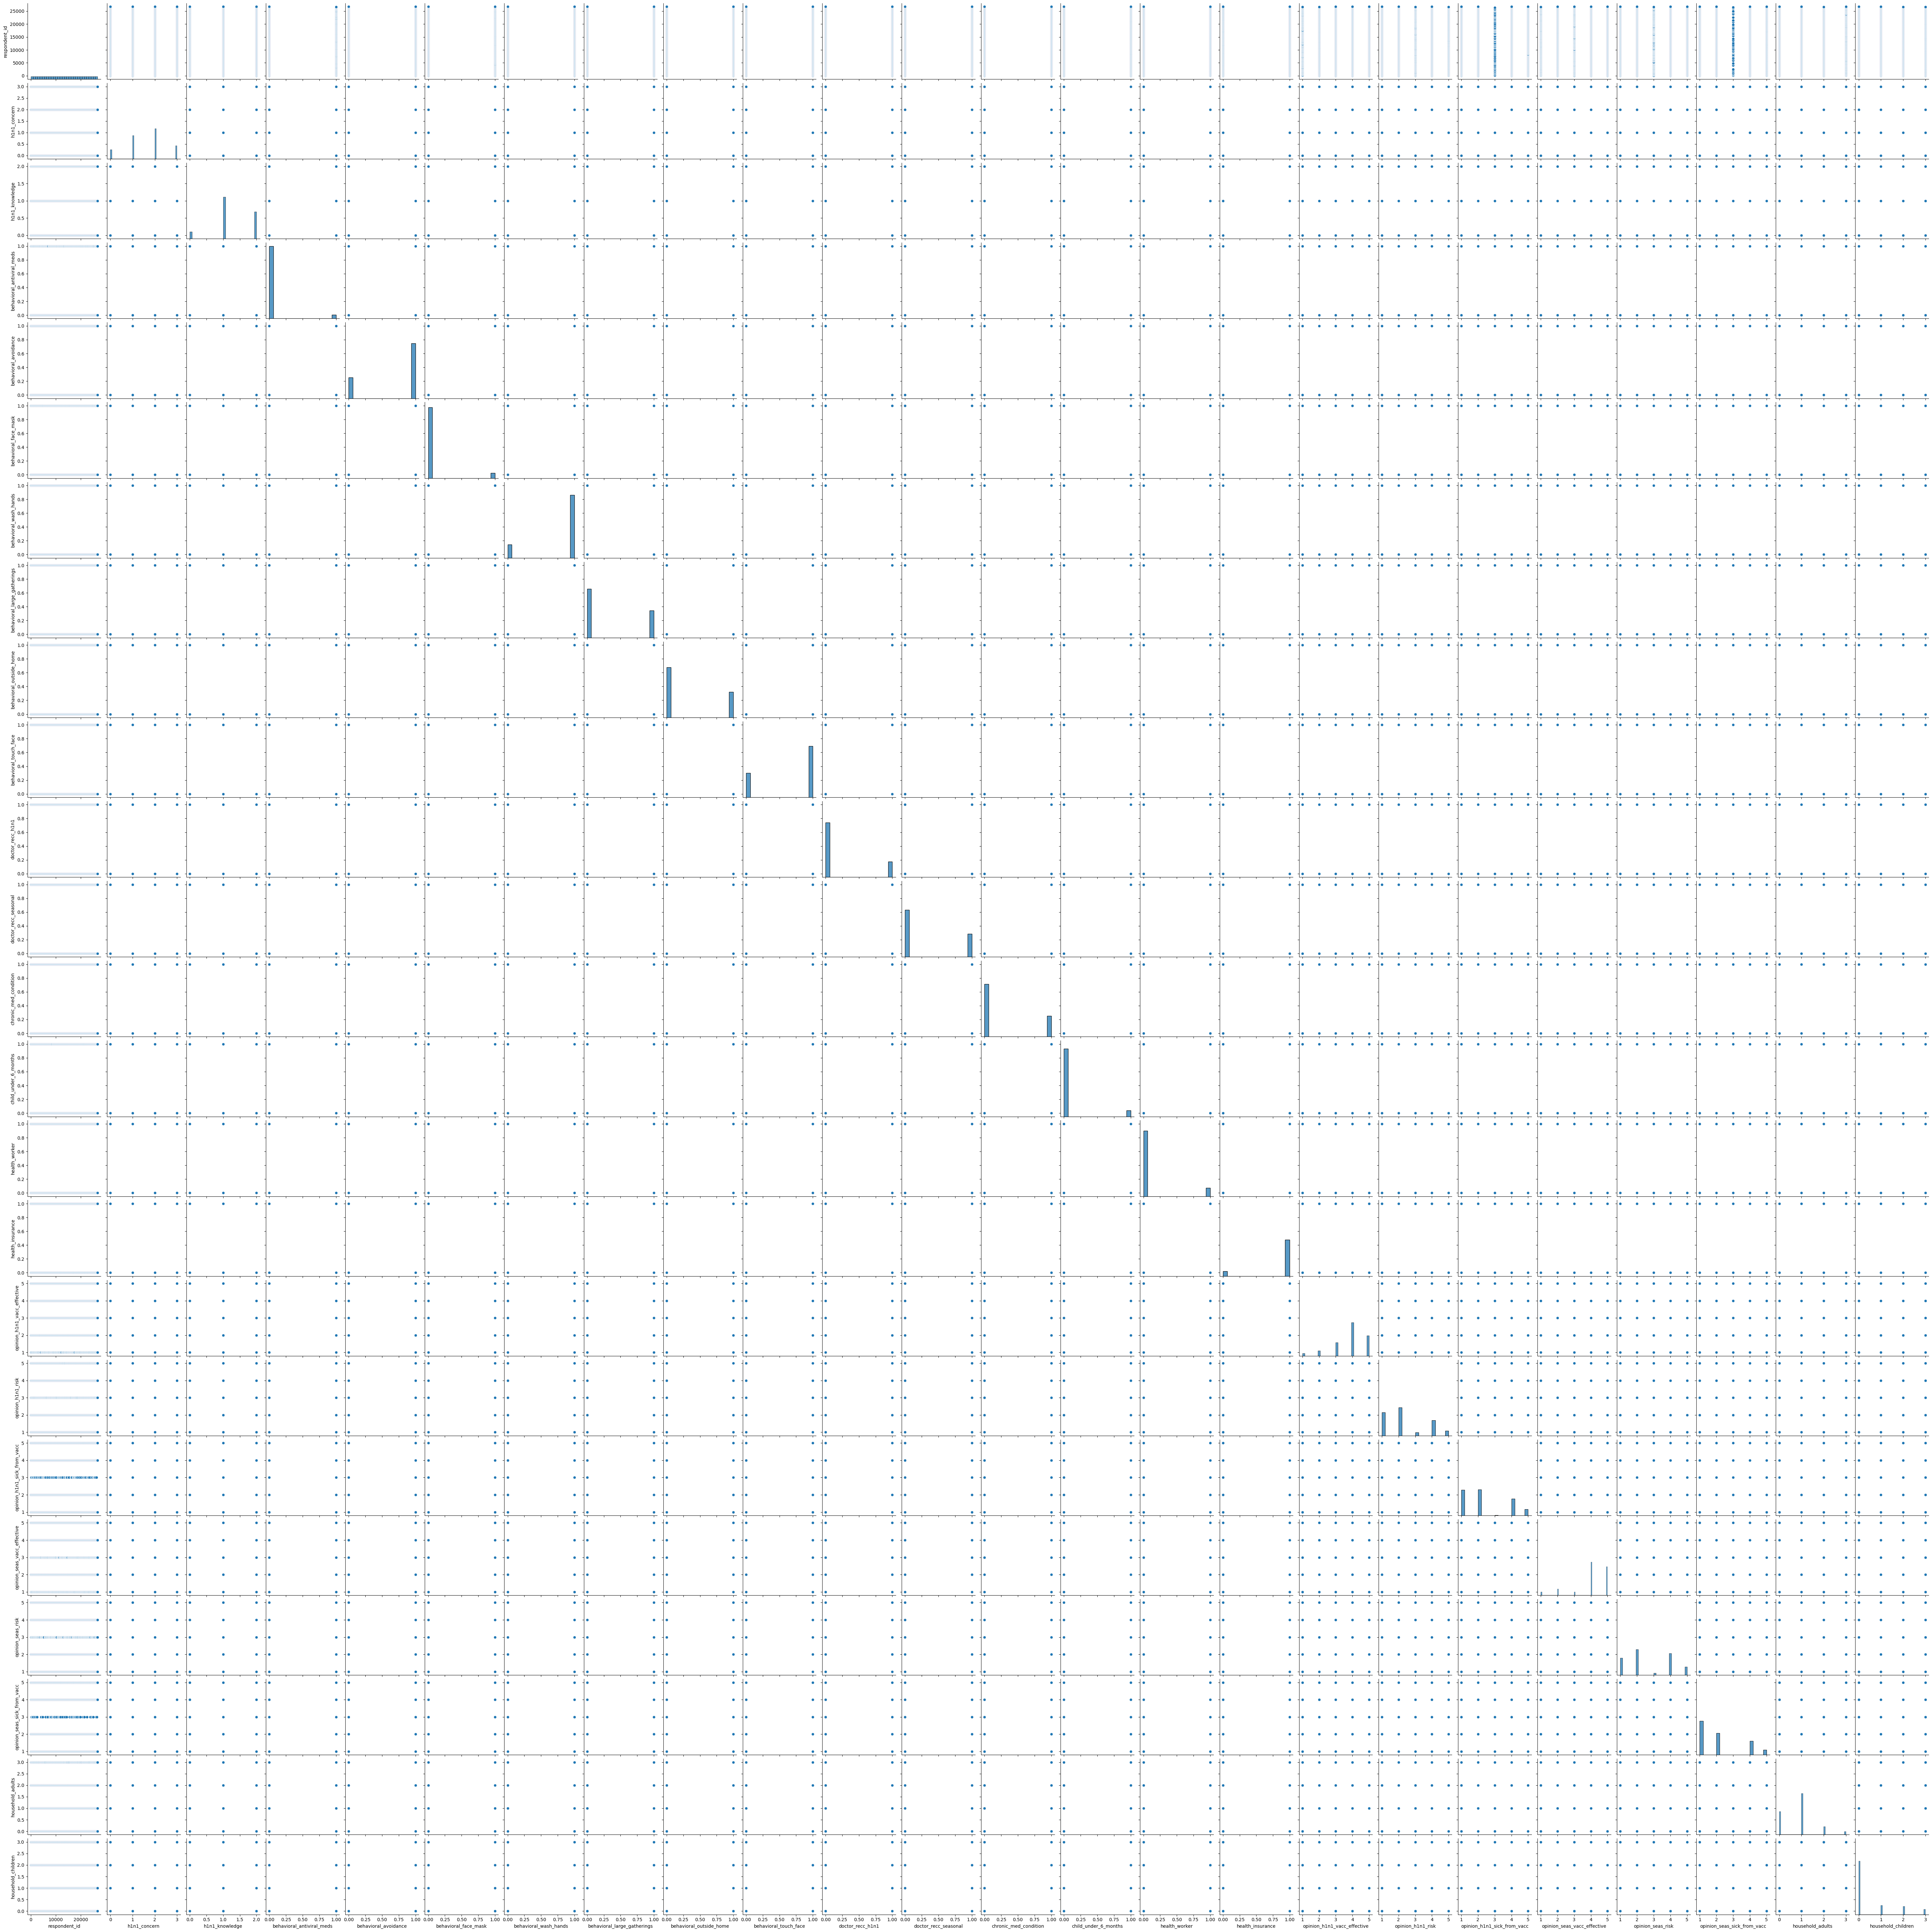

In [18]:
sns.pairplot(X_train)